In [1]:
from os import path
import pandas as pd
from matplotlib import pyplot as plt
import glob
from pydicom import dcmread

In [2]:
DDSM_dir = '/src/dermosxai/data/DDSM'
train_csv = path.join(DDSM_dir, 'mass_case_description_train_set.csv')
test_csv = path.join(DDSM_dir, 'mass_case_description_test_set.csv')

# original images downloaded from https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM (160 GB); Make sure to download with the "classic directory name" option
image_dir = '/mammograms'

## Read data

In [130]:
# Read csvs
train_df = pd.read_csv(train_csv)
test_df = pd.read_csv(test_csv)

# Join train and test data (just to avoid having the code run twice for each set)
train_df['split'] = 'train'
test_df['split'] = 'test'
df = pd.concat([train_df, test_df], ignore_index=True)

# Split the "train examples" to create a validation set (patient stratified sampling)
val_frac = 0.1 # fraction of training patients to assign to validation set
val_patients = train_df['patient_id'].drop_duplicates().sample(frac=val_frac, random_state=234)
df.loc[df['patient_id'].isin(val_patients), 'split'] = 'val'

df

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,split
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,train
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,train
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,train
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,train
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,P_01825,2,RIGHT,MLO,1,mass,LOBULATED,MICROLOBULATED,3,BENIGN_WITHOUT_CALLBACK,3,Mass-Test_P_01825_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Mass-Test_P_01825_RIGHT_MLO_1/1.3.6.1.4.1.9590...,Mass-Test_P_01825_RIGHT_MLO_1/1.3.6.1.4.1.9590...,test
1692,P_01833,2,RIGHT,MLO,1,mass,IRREGULAR,ILL_DEFINED,5,MALIGNANT,5,Mass-Test_P_01833_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Mass-Test_P_01833_RIGHT_MLO_1/1.3.6.1.4.1.9590...,Mass-Test_P_01833_RIGHT_MLO_1/1.3.6.1.4.1.9590...,test
1693,P_01865,2,LEFT,MLO,1,mass,IRREGULAR,ILL_DEFINED,4,MALIGNANT,2,Mass-Test_P_01865_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_01865_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_01865_LEFT_MLO_1/1.3.6.1.4.1.9590....,test
1694,P_01912,3,RIGHT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,4,Mass-Test_P_01912_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_01912_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_01912_RIGHT_CC_1/1.3.6.1.4.1.9590....,test


In [131]:
# Value counts for the categorical attributes
for attr in ['breast_density', 'subtlety', 'left or right breast', 'image view', 'abnormality id', 'mass shape', 'mass margins', 'assessment', 'pathology', 'split']:
    print(attr)
    print(df[attr].value_counts().sort_index())
    print()

breast_density
1    337
2    757
3    449
4    153
Name: breast_density, dtype: int64

subtlety
0      2
1     55
2    141
3    358
4    453
5    687
Name: subtlety, dtype: int64

left or right breast
LEFT     817
RIGHT    879
Name: left or right breast, dtype: int64

image view
CC     784
MLO    912
Name: image view, dtype: int64

abnormality id
1    1570
2      84
3      28
4      10
5       2
6       2
Name: abnormality id, dtype: int64

mass shape
ARCHITECTURAL_DISTORTION                    103
ASYMMETRIC_BREAST_TISSUE                     25
FOCAL_ASYMMETRIC_DENSITY                     25
IRREGULAR                                   464
IRREGULAR-ARCHITECTURAL_DISTORTION           52
IRREGULAR-ASYMMETRIC_BREAST_TISSUE            1
IRREGULAR-FOCAL_ASYMMETRIC_DENSITY            2
LOBULATED                                   384
LOBULATED-ARCHITECTURAL_DISTORTION            2
LOBULATED-IRREGULAR                           6
LOBULATED-LYMPH_NODE                          4
LOBULATED-OVAL  

'total patients 962'

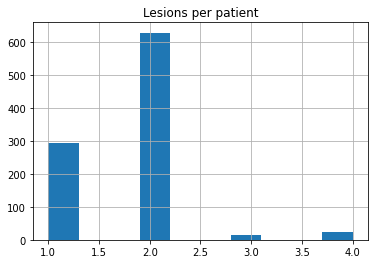

In [132]:
a = df.groupby(['patient_id', 'abnormality id']).count()['breast_density']
a.hist()
plt.title('Lesions per patient')

f'total patients {len(a)}'

## Get filenames

In [101]:
def get_filename(nbia_filename, is_mask_file=True):
    """ Go from the path in the csv to the actual path of the image in disk.
    
    Arguments:
        nbia_filename (str): Filename from the nbia metadata csv.
        is_mask_file (boolean): ROIs and cropped images are bundled in the
            same folder but the filenames do not have identifiable names and
            not enough information is provided in the metadata to know which
            is which so I have to check the tags of each file. When this flag
            is on, it returns the ROI file out of the two in the folder. If
            False and there's more than one file in the folder, it fails.
    """
    # Divide nbia_filename into relative directory and filename
    rel_dir, fake_filename = path.split(nbia_filename)
                            
    # Get filenames in folder (when more than one we have to actually open the files to see which is which)
    abs_dir = path.join(image_dir, rel_dir)
    filenames = glob.glob(path.join(abs_dir, '*.dcm'))
    
    # Find right filename (if more than one)
    if len(filenames) == 1:
        filename = filenames[0]
    elif is_mask_file:
        descriptions = [dcmread(f, stop_before_pixels=True).SeriesDescription for f in filenames]
        roi_filenames = [f for f, d in zip(filenames, descriptions) if d == 'ROI mask images']
        if len(roi_filenames) != 1:
            raise ValueError('More than one ROI file in the folder.')
        filename = roi_filenames[0]
    else:
        raise ValueError('More than one possible file to pick.')
    
    return filename

In [144]:
# Find the name of the mask and image files
df['image_path'] = df['image file path'].apply(get_filename, is_mask_file=False)
df['mask_path'] = df['ROI mask file path'].str.strip().apply(get_filename, is_mask_file=True) # the str.split is to drop the '/n' at the end of the name

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


### Drop rows with no mass shape or mass margins value

In [143]:
df = df.dropna()

## Standardize column and attribute names

In [145]:
# Drop unnecessary columns
df = df.drop(columns=['cropped image file path', 'image file path', 'ROI mask file path', 'abnormality type'])

In [146]:
# Make column names snake_case
df.columns = df.columns.str.replace(' ', '_')

In [147]:
# drop the P_ at the start and make it a number
df['patient_id'] = df['patient_id'].str.replace('P_', '').astype(int)

# replace spaces with underscores (e.g., "upper limbs" or "no further examination")
columns = ['left_or_right_breast', 'image_view', 'mass_shape', 'mass_margins', 'pathology']
for col in columns:
    df[col] = df[col].str.lower().str.replace('-', '/')

In [148]:
df

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,mass_shape,mass_margins,assessment,pathology,subtlety,split,image_path,mask_path
0,1,3,left,cc,1,irregular/architectural_distortion,spiculated,4,malignant,4,train,/mammograms/Mass-Training_P_00001_LEFT_CC/1.3....,/mammograms/Mass-Training_P_00001_LEFT_CC_1/1....
1,1,3,left,mlo,1,irregular/architectural_distortion,spiculated,4,malignant,4,train,/mammograms/Mass-Training_P_00001_LEFT_MLO/1.3...,/mammograms/Mass-Training_P_00001_LEFT_MLO_1/1...
2,4,3,left,cc,1,architectural_distortion,ill_defined,4,benign,3,train,/mammograms/Mass-Training_P_00004_LEFT_CC/1.3....,/mammograms/Mass-Training_P_00004_LEFT_CC_1/1....
3,4,3,left,mlo,1,architectural_distortion,ill_defined,4,benign,3,train,/mammograms/Mass-Training_P_00004_LEFT_MLO/1.3...,/mammograms/Mass-Training_P_00004_LEFT_MLO_1/1...
4,4,3,right,mlo,1,oval,circumscribed,4,benign,5,train,/mammograms/Mass-Training_P_00004_RIGHT_MLO/1....,/mammograms/Mass-Training_P_00004_RIGHT_MLO_1/...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1691,1825,2,right,mlo,1,lobulated,microlobulated,3,benign_without_callback,3,test,/mammograms/Mass-Test_P_01825_RIGHT_MLO/1.3.6....,/mammograms/Mass-Test_P_01825_RIGHT_MLO_1/1.3....
1692,1833,2,right,mlo,1,irregular,ill_defined,5,malignant,5,test,/mammograms/Mass-Test_P_01833_RIGHT_MLO/1.3.6....,/mammograms/Mass-Test_P_01833_RIGHT_MLO_1/1.3....
1693,1865,2,left,mlo,1,irregular,ill_defined,4,malignant,2,test,/mammograms/Mass-Test_P_01865_LEFT_MLO/1.3.6.1...,/mammograms/Mass-Test_P_01865_LEFT_MLO_1/1.3.6...
1694,1912,3,right,cc,1,irregular,spiculated,5,malignant,4,test,/mammograms/Mass-Test_P_01912_RIGHT_CC/1.3.6.1...,/mammograms/Mass-Test_P_01912_RIGHT_CC_1/1.3.6...


## Save

In [149]:
df.to_csv(path.join(DDSM_dir, 'image_info.csv'), index=False)

## Create h5 dataset with all images
1. Crop the images using the mask and adding some padding around them.
2. Resize everything to 128 x 128

In [3]:
import pandas as pd
from os import path
from pydicom import dcmread
import matplotlib.pyplot as plt

from skimage import measure
from PIL import Image
import numpy as np

In [4]:
# Get image info
df = pd.read_csv(path.join(DDSM_dir, 'image_info.csv'))

### Check original sizes and aspect ratios
Just to make sure what we are doing makes sense

In [ ]:
masks = [dcmread(f).pixel_array for f in df['mask_path']] # this takes 5-10 minutes, maybe just pick the first 500 or so

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(masks[0]) # 

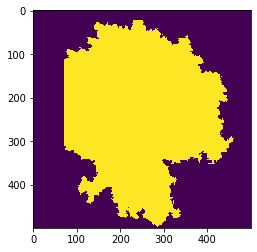

In [13]:
plt.imshow(masks[0][2400:2900, 200:700], interpolation='none')

In [14]:
props = [measure.regionprops(r)[0] for r in masks] # takes 30 secs
bboxes = [p.bbox for p in props]
aspect_ratios = [(bbox[2] - bbox[0]) / (bbox[3] - bbox[1]) for bbox in bboxes]
bbox_length = [np.sqrt((bbox[2] - bbox[0]) * (bbox[3] - bbox[1])) for bbox in bboxes]

Text(0.5, 1.0, 'Aspect ratio of ROIs')

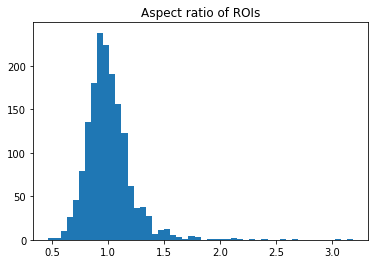

In [15]:
plt.hist(aspect_ratios, bins=50)
plt.title('Aspect ratio of ROIs')

Text(0.5, 1.0, 'Expected size of bbox')

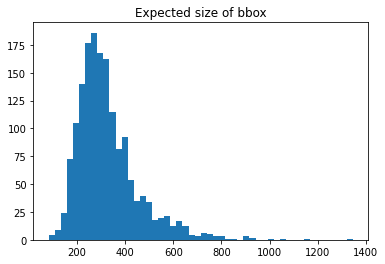

In [16]:
plt.hist(bbox_length, bins=50)
plt.title('Expected size of bbox')

## Process images

In [5]:
def pad_if_possible(low, up, pad_amount, min_value, max_value):
    """ Return the updated lower and upper coordinates after padding.
    
    It pads the same amount on each side. If padding takes the coordinates
    outside the min or max value, it reduces the padding.
    """
    if low - pad_amount < min_value:
        pad_amount = low - min_value
    if up + pad_amount > max_value:
        pad_amount = max_value - up
    return low - pad_amount, up + pad_amount
    
# Get bboxes
pad_perc = 0.025 # percentage of pixels used for padding around the bboxes
bboxes = []
cropped_masks = [] # just to check everything looks ok
for mask_path in df['mask_path']:
    # Get bbox measurements
    mask = dcmread(mask_path).pixel_array
    bbox = measure.regionprops(mask)[0].bbox # (min_row, min_col, max_row, max_col)
    
    # Pad bbox
    row_padding = int(round(pad_perc * (bbox[2] - bbox[0])))
    row_low, row_up = pad_if_possible(bbox[0], bbox[2], row_padding, min_value=0, max_value=mask.shape[0])
    col_padding = int(round(pad_perc * (bbox[3] - bbox[1])))
    col_low, col_up = pad_if_possible(bbox[1], bbox[3], col_padding, min_value=0, max_value=mask.shape[1])
    padded_bbox = (row_low, col_low, row_up, col_up)
   
    bboxes.append(padded_bbox)
    cropped_masks.append(mask[padded_bbox[0]: padded_bbox[2], padded_bbox[1]: padded_bbox[3]].copy()) # copy just to release the original array

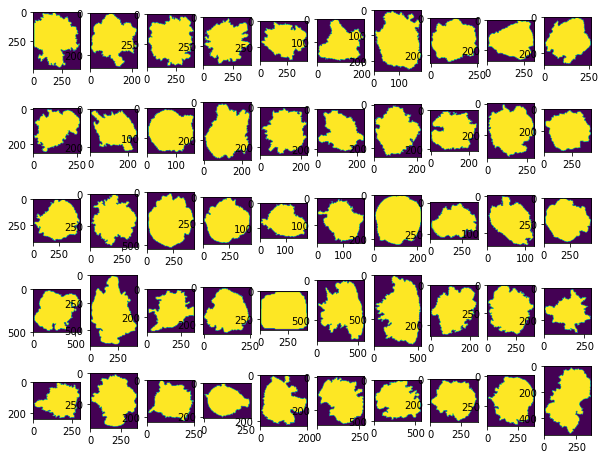

In [6]:
fig, axes = plt.subplots(5, 10, figsize=(10, 8))
for im, ax in zip(cropped_masks, axes.ravel()):
    ax.imshow(im)

In [7]:
# Crop
cropped_ims = []
for bbox, image_path in zip(bboxes, df['image_path']):
    # Load image
    img = dcmread(image_path).pixel_array
    
    # Crop
    cropped = img[bbox[0]: bbox[2], bbox[1]: bbox[3]]
    cropped_ims.append(cropped.copy()) # copy just to release the original array

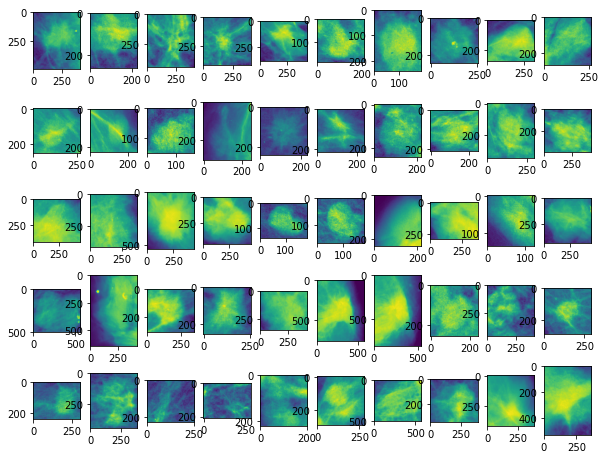

In [8]:
fig, axes = plt.subplots(5, 10, figsize=(10, 8))
for im, ax in zip(cropped_ims, axes.ravel()):
    ax.imshow(im)

In [9]:
# Resize
out_size = (128, 128) # this changes aspect ratio !
resized_ims = []
for im in cropped_ims:
    pil_image = Image.fromarray(im.astype(np.float32)) # need the change to float to use bicubic or lanczos resampling
    resized_im = pil_image.resize(out_size, resample=Image.LANCZOS, reducing_gap=3)
    resized_ims.append(np.array(resized_im))

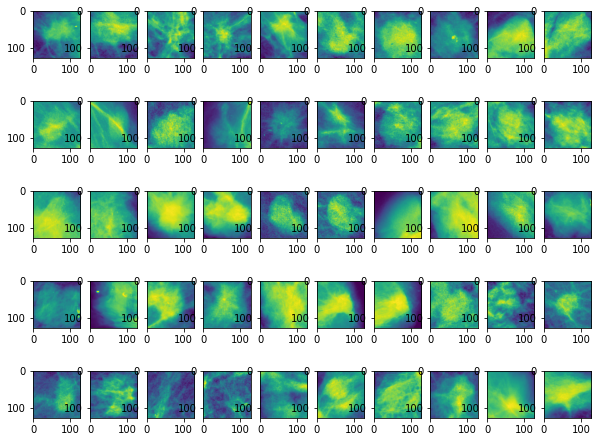

In [10]:
fig, axes = plt.subplots(5, 10, figsize=(10, 8))
for im, ax in zip(resized_ims, axes.ravel()):
    ax.imshow(im)

## Save images

In [11]:
import h5py

im_array = np.stack(resized_ims) # num_images x 128 x 128
with h5py.File(path.join(DDSM_dir, 'images.h5'), 'w') as f:
    f.create_dataset('images', data=im_array)